In [257]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data as data

%matplotlib inline

## Linear Regression

In [238]:
noise_var = 0.1
num_data = 50
num_features = 2
prior_var = 1.

X = np.random.randn(num_data, num_features)
w_true = np.random.randn(num_features, 1) * np.sqrt(noise_var)
noise = np.random.randn(num_data, 1) * np.sqrt(noise_var)
y = X.dot(w_true) + noise

In [239]:
w_grid_x = np.linspace(-1, 1, num=100)
w_grid_y = np.linspace(-1, 1, num=100)
w_grid_x, w_grid_y = np.meshgrid(w_grid_x, w_grid_y)

In [240]:
w_grid_x = w_grid_x.reshape(-1)[:, None]
w_grid_y = w_grid_y.reshape(-1)[:, None]
w_grid = np.hstack([w_grid_x, w_grid_y])

Prior: $p(w) = \mathcal{N}(0, I)$. Likelihood: $p(y \vert w) = \mathcal{N}(0, 0.1 \cdot I)$

Posterior $p(w \vert y) \propto p(w) p(y \vert w)$.

### True posterior:

In [241]:
# prior parameters
S0 = np.eye(num_features) * prior_var
m0 = np.zeros([num_features, 1])

beta = 1 / noise_var

# posterior parameters
S0_inv = np.linalg.inv(S0)
Sn_inv = S0_inv + beta * X.T.dot(X)
Sn = np.linalg.inv(Sn_inv)


mn = Sn.dot(S0_inv.dot(m0) + beta * X.T.dot(y))

In [739]:
true_posterior = multivariate_normal(mean=mn[:, 0], cov=Sn)

In [1098]:
w_samples = np.random.multivariate_normal(mn[:, 0], Sn, size=5000)

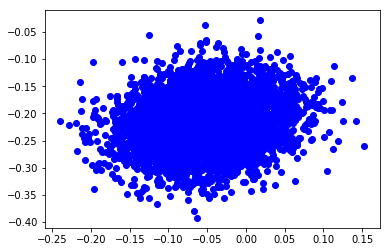

In [1099]:
plt.plot(w_samples[:, 0], w_samples[:, 1], 'bo')

### SGHMC

In [896]:
class RegDataset(data.Dataset):
    
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
        
    def __len__(self):
        return self.X.size()[0]
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [1048]:
dataset = RegDataset(X, y)
dataloader = data.DataLoader(dataset, batch_size=10, shuffle=True)

In [1049]:
class SGHMC:
    
    def __init__(self, var, alpha, eta, log_density, num_data):
        """
        Stochastic Gradient Monte Carlo sampler.
        
        Args:
            var: `Variable` corresponding to the variable that is sampled
            alpha: momentum parameter
            eta: learning rate parameter
            log_density: function computing log_density for a given sample
                and batch of data
        """
        self.var = var
        self.alpha = alpha
        self.eta = eta
        self.log_density = log_density
        self.dataloader = dataloader
        self.optimizer = optim.SGD([self.var], lr=1, momentum=(1 - self.alpha))
        self.num_data = num_data
    
    def _noise(self):
        std = np.sqrt(2 * self.alpha * self.eta)
        n = Variable(torch.normal(0, std= std * torch.ones(self.var.size())))
        return torch.sum(n * self.var)
        
    def sample(self, x_batch, y_batch):
        loss = self.log_density(self.var, x_batch, y_batch) * self.eta
        loss += self._noise() / self.num_data
        loss.backward()
        self.optimizer.step()
        self.var.grad.data.zero_()
#         print(self.var.grad)
        return self.var

In [1050]:
class BayesianLinearRegression:

    def __init__(self, prior_std, noise_std, num_data):
        self.prior_std = prior_std
        self.noise_std = noise_std
        self.num_data = num_data
    
    def log_prior(self, w):
        return - torch.sum(w**2 / (2 * self.prior_std**2))

    def log_posterior_density(self, w, X_batch, y_batch):
        Xv = Variable(X_batch)
        yv = Variable(y_batch)[:, 0]
        preds = torch.matmul(Xv, w)
        loss = - torch.mean((preds - yv)**2 /(2 * self.noise_std**2))
        loss += self.log_prior(w)/ self.num_data
        return -loss

### Sampling

In [1129]:
w = torch.from_numpy(np.random.multivariate_normal(m0[:, 0], S0)).float()
w_v = Variable(w, requires_grad=True)
bayes_reg = BayesianLinearRegression(np.sqrt(prior_var), np.sqrt(noise_var), X.shape[0])
sghmc = SGHMC(w_v, .01, 5e-3, bayes_reg.log_posterior_density, X.shape[0])

In [1131]:
samples = []
for epoch in range(10000):
    for i, data_ in enumerate(dataloader, 0):
        x_batch, y_batch = data_
        w_sample = sghmc.sample(x_batch, y_batch)
        samples.append(np.copy(w_sample.data.numpy()))
    if not(epoch % 100):
        print(epoch)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [1132]:
samples = np.vstack(samples)
samples.shape

(50000, 2)

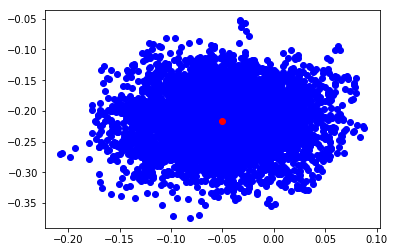

In [1133]:
start_from=45000
plus = 5000
plt.plot(samples[start_from:start_from+plus, 0], samples[start_from:start_from+plus, 1], 'bo')
plt.plot(mn[0] ,mn[1], 'ro')

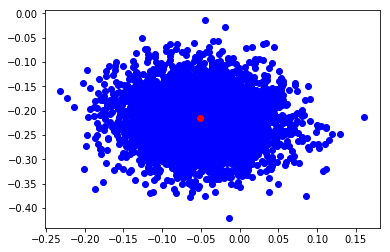

In [1134]:
freq = 10
new_samples = []
for i in range(int(samples.shape[0] / freq))[100:]:#[400:]:
    new_samples.append(samples[i * freq][None, :])
new_samples = np.vstack(new_samples)
plt.plot(new_samples[:, 0], new_samples[:, 1], 'bo')
plt.plot(mn[0] ,mn[1], 'ro')

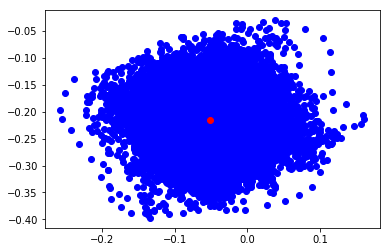

In [1147]:
start_from=10000
plus = 20000
plt.plot(samples[start_from:start_from+plus, 0], samples[start_from:start_from+plus, 1], 'bo')
plt.plot(mn[0] ,mn[1], 'ro')